In [85]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

#### Get images

In [86]:
root_path = Path(r"/mnt/c/users/msi/Desktop/spr_datasets")
image_path_list = list(root_path.glob("*/annotated/*.png"))
print(len(image_path_list))

344


#### Define image-resizing function

In [87]:
def adjust_ratio_and_resize_image(path, to_h, to_w, save_folder_path=None):
    # load an image
    img = Image.open(path)

    # set the basic info
    target_ratio = 0.75
    h = img.height
    w = img.width
    ratio = h / w
    new_ratio = 0.00

    # get new length according to the target ratio
    if ratio != target_ratio:
        if ratio < target_ratio:
            new_length = int(w * target_ratio)
            half = (new_length - h) // 2
        elif ratio > target_ratio:
            new_length = int(h / target_ratio)
            half = (new_length - w) // 2

        another_half = new_length - half - h if 2 * half != new_length else half

        # adjust ratio by padding in reflection mode
        img_np = np.array(img)
        if ratio < target_ratio:
            img_padded = np.pad(img_np, ((half, another_half), (0, 0), (0, 0)), "reflect")
        elif ratio > target_ratio:
            img_padded = np.pad(img_np, ((0, 0), (half, another_half), (0, 0)), "reflect")

        new_ratio = img_padded.shape[0] / img_padded.shape[1]
        assert f"{target_ratio :.2f}" == f"{new_ratio :.2f}", f"{target_ratio =}, {new_ratio =}"
        img = Image.fromarray(img_padded)
        
    # downsize the image
    img = img.resize((to_w, to_h), Image.Resampling.NEAREST)
    if save_folder_path is None:
        return img
        
    # if to save
    save_folder = Path(save_folder_path)
    if save_folder.exists():
        # print("... folder exists already")
        pass
    else:
        save_folder.mkdir()
        # print(f"...{save_folder} made!")

    # save
    img.save(save_folder / path.parts[-1])
    return img



#### Head height function

In [88]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from copy import deepcopy
from pathlib import Path
import datetime
import argparse
import torch

BACKGROUND = [0, 0, 0]
LOWER = [255, 96, 55]
MIDDLE = [221, 255, 51]
RIVET = [61, 245, 61]
UPPER = [61, 61, 245]
COLOUR_NAMES = {
    "BACKGROUND": BACKGROUND,
    "LOWER": LOWER,
    "MIDDLE": MIDDLE,
    "RIVET": RIVET,
    "UPPER": UPPER,
    }
RIVET_DIAMETER = 7.75

def get_image_array(path):
    img_arr = None
    
    img = Image.open(path)
    if img is not None:
        img_arr = np.array(img)
    
    return img_arr

def colour_quantisation(arr_original):
    arr = deepcopy(arr_original)
    colours = [BACKGROUND, LOWER, MIDDLE, RIVET, UPPER]

    # print(f"...before quantisation: {len(np.unique(arr)) = }")
    for w in range(arr.shape[0]):
        for h in range(arr.shape[1]):
            max_diff = 255 * 3
            temp_diff = 0
            current_pixel = arr[w, h]
            quantised_pixel = [255, 255, 255]
            set_channel_idx = None
            # print(current_pixel)
            
            # 있는지 확인
            matching_flag = False
            for c in colours:
                if (current_pixel == c).all():
                    matching_flag = True
            if matching_flag:
                continue       
                    
            for colour_idx, c in enumerate(colours):
                # print(f"[{COLOUR_NAMES[colour_idx]}] : {c}")
                
                for channel_idx in range(arr.shape[2]):
                    temp_diff += np.abs(current_pixel[channel_idx] - c[channel_idx])
                    # print(f"{temp_diff = }")
                
                if temp_diff == 0:
                    continue
                
                elif temp_diff < max_diff:
                    # print(f"It's smaller!, [{colour_idx}] colour, [{COLOUR_NAMES[colour_idx]}]")
                    max_diff = temp_diff
                    quantised_pixel = colours[colour_idx]
                    set_channel_idx = colour_idx
                
                temp_diff = 0
                # print(f"[{max_diff = }]")
            arr[w, h] = quantised_pixel
            # print(f"before: {current_pixel}, after: {quantised_pixel} -> [{COLOUR_NAMES[set_channel_idx]}]")

    # print(f"...after quantisation: {len(np.unique(arr)) = }")
    return arr

def get_line_coords_via_corners(img_arr, colour, is_upper_corner=True):
    condition_1 = img_arr[:, :, 0] == colour[0]
    condition_2 = img_arr[:, :, 1] == colour[1]
    condition_3 = img_arr[:, :, 2] == colour[2]
    
    channel_1_coords, channel_2_coords = np.where(condition_1 & condition_2 & condition_3)
    
    # 모서리 기준점 좌표 설정
    h = img_arr.shape[0]
    w = img_arr.shape[1]
    if is_upper_corner:
        left_coord = [0, 0]
        right_coord = [w - 1, 0]
    else:
        left_coord = [0, h - 1]
        right_coord = [w - 1, h - 1]
    
    # 최대 거리 설정
    max_diff_left = h * w
    max_diff_right = h * w
    
    # 찾아낸 좌표들 기본값 설정
    left_x = None
    left_y = None

    right_x = None
    right_y = None

    # 좌표 값마다 모서리 기준점과 거리(L1) 비교
    # --- 이미지 표현에서 첫번째 채널 값은 y축, 두번째 채널 값은 x축을 표현
    for y, x in zip(channel_1_coords, channel_2_coords):
        left_distance = np.abs(left_coord[0] - x) + np.abs(left_coord[1] - y)
        right_distance = np.abs(right_coord[0] - x) + np.abs(right_coord[1] - y)
        
        if left_distance < max_diff_left:
            left_x = x
            left_y = y
            # print(f"left coords found [{left_y}, {left_x}]")
            max_diff_left = left_distance
            
        elif right_distance < max_diff_right:
            right_x = x
            right_y = y
            max_diff_right = right_distance
            # print(f"right coords found [{right_y}, {right_x}]")

    # visualise(img_arr, [left_x, right_x], [left_y, right_y], fig_save_folder, True)    
    return left_x, left_y, right_x, right_y

def get_matrix(x1, y1, x2, y2):
    matrix = np.array([
        [x1, x2],
        [y1, y2]
    ])
    
    return matrix


def rotate_vector_around_origin(vector, rad):
    x, y = vector
    if rad > 0:
        xx = x * math.cos(rad) + y * math.sin(rad)
        yy = -x * math.sin(rad) + y * math.cos(rad)
    elif rad < 0:
        xx = x * math.cos(rad) + -y * math.sin(rad)
        yy = x * math.sin(rad) + y * math.cos(rad)
    else:
        xx = x
        yy = y        
    
    rotated_vector = np.array([xx, yy])
    # print("====== rotate ======")
    # print(f"original vector: \n{vector}\nrad: {rad}\n")
    # print(f"rotated vector: \n{rotated_vector}")
    # print("====================")
    return rotated_vector

def rotate_vector(vector, two_y_points, rad):
    x, y = vector
    left_y, right_y = two_y_points
    c, s = np.cos(rad), np.sin(rad)
    
    # y축에서 0이 더 높이 위치한 이미지상에서 left_y 가 right_y보다 더 높은 값을 갖는다면,
    # 더 낮게 위치하고 있으므로 clockwise로 진행 필요
    if left_y > right_y:
        j = np.matrix([
            [c, -s],
            [s, c]
        ])
        
    # 반대로 counter-clockwise
    elif left_y < right_y:
        j = np.matrix([
            [c, s],
            [-s, c]
        ])
    else:
        j = np.matrix([
            [1, 0],
            [0, 1]
        ])
        
    m = np.dot(j, [x, y])
    rotated_vector = np.array([m.T[0].item(), m.T[1].item()], dtype=float)

    # print("====== rotate ======")
    # print(f"original vector: \n{vector}\nrad: {rad}\n")
    # print(f"rotated vector: \n{rotated_vector}")
    # print("====================")
    
    return rotated_vector

def get_angle_between_two_vectors_from_origin(u, v):
    cos_theta = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    deg = np.degrees(rad)
    
    # apply minus multiplication if the image should be rotated clockwise
    if u[1] < v[1]:
        rad = -rad
        deg = -deg
    
    # print("--- get angle between two vectors ---")
    # print(f"u: \n{u}\nv: \n{v}")
    # print(f"rad: {rad}, deg: {deg}")
    # print("-------------------------------------")
    return rad, deg

def move_to_origin(matrix, x1, y1):
    matrix_copy = deepcopy(matrix)

    # 0,0 으로 origin(x1, y1) 옮기기
    matrix_copy[0, 0] -= x1
    matrix_copy[0, 1] -= x1
    matrix_copy[1, 0] -= y1
    matrix_copy[1, 1] -= y1
    # print("--- move to origin ---")
    # print(f"before: \n{matrix}\nafter: \n{matrix_copy}")
    # print("----------------------")
    return matrix_copy

def move_to_x_axis_with_origin_anchored(matrix):
    # x축으로 거리 유지하며 vector 옮기기
    vector_length = np.sqrt((matrix[0, 1] - matrix[0, 0]) ** 2 + (matrix[1, 1] - matrix[1, 0]) ** 2)
    matrix_on_x_axis = [
        [0, vector_length],
        [0, 0]
    ]

    matrix_on_x_axis = np.array(matrix_on_x_axis)

    # print("--- move to x axis ---")
    # print(f"length: {vector_length}\nafter: \n{matrix_on_x_axis}")
    # print("----------------------")
    
    return matrix_on_x_axis

def get_rotated_image_rivet_coords(img_arr):
    # 리벳 직경 좌표 구하기
    left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet = get_line_coords_via_corners(img_arr, RIVET, True)

    # 리벳 직경 좌표 매트릭스로 변형
    rivet_matrix = get_matrix(left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet)

    # origin으로 보낼 때 필요한 x축, y축 차이
    x_diff = rivet_matrix[0, 0]
    y_diff = rivet_matrix[1, 0]

    # origin으로 보내진 리벳 직경 매트릭스
    rivet_origin = move_to_origin(rivet_matrix, x_diff, y_diff)

    # origin을 기점으로 x축으로 내려온 리벳 직경 매트릭스
    rivet_on_x_axis = move_to_x_axis_with_origin_anchored(rivet_origin)

    # 두 벡터 간 각도 계산
    rad, deg = get_angle_between_two_vectors_from_origin(rivet_origin.T[1], rivet_on_x_axis.T[1])

    # rotate
    img = Image.fromarray(img_arr)
    img_rotated = img.rotate(deg)
    img_rotated_arr = np.array(img_rotated)
    return img_rotated_arr, (left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet)

def get_thickness_of_plate(coords, img_arr, colour):
    result_coords = []
    result_lengths = []
    
    for x, y in coords:
        original_x = x
        original_y = y

        tmp_length = 0
        tmp_coords = (x, y)
        reached = False
        
        while not reached:
            
            # assume drawing a line needs to be done from top to bottom
            y += 1
            
            if all(img_arr[y, x, :] == colour):
                tmp_coords = (x, y)
            else:
                tmp_length = abs((y - 1) - original_y)
                
                if tmp_length > 0:
                    result_lengths.append(tmp_length)
                    result_coords.append(tmp_coords)
                else:
                    result_lengths.append(None)
                    result_coords.append(None)
                
                reached = True
    # if result_coords[0] is not None:
    #     for idx, (c, rc) in enumerate(zip(coords, result_coords)):
    #         if idx == 0:
    #             visualise(img_arr, [c[0], rc[0]], [c[1], rc[1]], fig_save_folder, True)
    #         else:
    #             visualise(img_arr, [c[0], rc[0]], [c[1], rc[1]], fig_save_folder, False)
    return result_coords, result_lengths

def calculate_weighted_mm_per_pixel(img_rotated_arr: np.array, 
                                    plates: list | tuple, 
                                    mms: list | tuple,
                                    weights: list | tuple=None,
                                    ):
    """
    This function assumes the elements for calculation put in as an argument
    are ordered where the rivet info is placed at first.
    Other elements don't need to be considered in the order.
    """
    weighted_mm_per_pixel = 0.0
    
    left_xs = []
    left_ys = []
    right_xs = []
    right_ys = []

    # 가중치가 주어지지 않은 경우 균등한 가중치 적용    
    # print(f"...weights received: {weights = }")
    if weights is None:
        value = 1 / len(mms)
        weights = [value] * len(mms)
        
        # to sum up to 1
        if sum(weights) != 1:
            weights[0] = 1 - sum(weights[1:])

        # print(f"...weights modified: {weights = }")

    for idx, plate_colour in enumerate(plates):        
        lx, ly, rx, ry = get_line_coords_via_corners(img_rotated_arr, plate_colour, True)
        left_xs.append(lx)
        left_ys.append(ly)
        right_xs.append(rx)
        right_ys.append(ry)

        weight = weights[idx]
        mm = mms[idx]
        
        # 리벳일 경우 직경을 통해 mm per pixel 산출
        if plate_colour == RIVET and idx == 0:
            pixel = abs(rx - lx)
        # 그 외의 경우 두께를 통해 mm per pixel 산출
        else:
            tmp_coords, tmp_lengths = get_thickness_of_plate([[lx, ly], [rx, ry]], img_rotated_arr, plate_colour)
            tmp_lengths = [x for x in tmp_lengths if x is not None]
            pixel = max(tmp_lengths)
        
        tmp_mm_per_pixel = mm / pixel
        # print(f"...{idx = } / {plate_colour = } / {tmp_mm_per_pixel = }")
        tmp_weighted_mm_per_pixel = tmp_mm_per_pixel * weight
        # print(f"...{idx = } / {plate_colour = } / {tmp_weighted_mm_per_pixel = }")
        weighted_mm_per_pixel += tmp_weighted_mm_per_pixel
    
    # print(f"...... {weighted_mm_per_pixel = }")
    return weighted_mm_per_pixel


def get_middle_coords(lx, ly, rx, ry):
    middle_x = int((lx + rx) / 2)
    middle_y = int((ly + ry) / 2)
    return middle_x, middle_y

def get_coords_from_centre_for_both_sides(diameter_mm, middle_x, weighted_mm_per_pixel):
    """
    This function assumes the aim is to get coords that are distanced
    from the center by a certain mm, and when trying to distance the coordinates,
    y-axis value doesn't need to be considered, because they are all aligned in parallel
    to x-axis
    """
    half_mm = diameter_mm / 2
    half_pixel = half_mm / weighted_mm_per_pixel

    left_x_further = int(middle_x - half_pixel)
    right_x_further = int(middle_x + half_pixel)
    return left_x_further, right_x_further

def get_colour_touching_coords_by_moving_on_x_axis(img_rotated_arr, x, y, colour, towards_left):
    is_not_on_colour = any(img_rotated_arr[y, x, :] != colour)
    
    if towards_left:
        while is_not_on_colour:
            x -= 1
            is_not_on_colour = all(img_rotated_arr[y, x, :] != colour)
    else:
        while is_not_on_colour:
            x += 1
            is_not_on_colour = all(img_rotated_arr[y, x, :] != colour)
    # print(f"...modified {x = } / {y = }")   
    return x, y    

def get_colour_touching_coords_by_moving_on_y_axis(img_rotated_arr, x, y, colour):
    if x < 0:
        # print(f"... x value goes beyond the fig / {x = }")
        x = 0
        x, y = get_colour_touching_coords_by_moving_on_x_axis(img_rotated_arr, x, y, colour, False)
    elif x >= img_rotated_arr.shape[1]:
        # print(f"... x value goes beyond the fig / {x = }")
        x = img_rotated_arr.shape[1] - 1
        x, y = get_colour_touching_coords_by_moving_on_x_axis(img_rotated_arr, x, y, colour, True)

    is_hovering = any(img_rotated_arr[y, x, :] != colour)
    
    if is_hovering:
        while is_hovering:
            y += 1
            is_hovering = all(img_rotated_arr[y, x, :] != colour)
    else:
        is_on_colour = not is_hovering
        while is_on_colour:
            y -= 1
            is_on_colour = all(img_rotated_arr[y, x, :] == colour)
    return x, y

def create_base_image(path, is_from_gen):

    # 이미지 어레이 가져오기
    img_arr = None
    if isinstance(path, str) or isinstance(path, Path):
        img_arr = get_image_array(path)
    elif isinstance(path, np.ndarray):
        img_arr = path
    elif isinstance(path, torch.Tensor):
        img_arr = path.numpy().transpose(1, 2, 0)
    
    # 생성된 이미지일 경우 양자화
    if is_from_gen:
        img_arr = colour_quantisation(img_arr)

    # 이미지를 rivet 직경에 수평하게 rotate
    img_rotated_arr, (left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet) = get_rotated_image_rivet_coords(img_arr)
    return img_rotated_arr, (left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet)

def select_plates_for_mm_calculation(upper_type, 
                                     upper_thickness,
                                     middle_type, 
                                     middle_thickness,
                                     lower_type,
                                     lower_thickness):
    plates = [RIVET]
    mms = [RIVET_DIAMETER]
    
    if upper_type.lower().startswith("s"):
        plates.append(UPPER)
        mms.append(upper_thickness)
    
    if middle_type is not None and middle_type.lower().startswith("s"):
        plates.append(MIDDLE)
        mms.append(middle_thickness)
    
    if lower_type.lower().startswith("s"):
        plates.append(LOWER)
        mms.append(lower_thickness)
    
    plate_names = [list(COLOUR_NAMES.keys())[list(COLOUR_NAMES.values()).index(p)] for p in plates]
    # print(f"...selected: {plate_names = } / {mms = }")
    return plates, mms


def get_head_height(img_rotated_arr, 
                    lx_rivet, 
                    ly_rivet, 
                    rx_rivet, 
                    ry_rivet, 
                    diameter_mm, 
                    weighted_mm_per_pixel,
                    to_save_fig=False):    
    
    # 리벳 중간점 구하기
    middle_x, middle_y = get_middle_coords(lx_rivet, ly_rivet, rx_rivet, ry_rivet)
    # visualise(img_rotated_arr, [middle_x], [middle_y], fig_save_folder, True)
    
    # 리벳에서 양쪽으로 떨어진 두 점 구하기
    lx_further, rx_further = get_coords_from_centre_for_both_sides(diameter_mm, middle_x, weighted_mm_per_pixel)
    # visualise(img_rotated_arr, [lx_further, rx_further], [middle_y, middle_y], fig_save_folder, True)

    # 리벳 양쪽 두 점이 upper와 만나는 점 구하기
    lx_further, ly_touching = get_colour_touching_coords_by_moving_on_y_axis(img_rotated_arr, lx_further, middle_y, UPPER)
    rx_further, ry_touching = get_colour_touching_coords_by_moving_on_y_axis(img_rotated_arr, rx_further, middle_y, UPPER)
    
    # visualise(img_rotated_arr, [lx_further, rx_further], [ly_touching, ry_touching], fig_save_folder, True)
    
    # upper 위 두 점의 중간점 구하기
    upper_middle_x_on_line, upper_middle_y_on_line = get_middle_coords(lx_further, ly_touching, rx_further, ry_touching)
    # visualise(img_rotated_arr, [upper_middle_x_on_line], [upper_middle_y_on_line], fig_save_folder, False)

    # upper 기준선 위 중간점이 리벳에 닿는 점 구하기
    rivet_x_touching, rivet_y_touching = get_colour_touching_coords_by_moving_on_y_axis(img_rotated_arr, upper_middle_x_on_line, upper_middle_y_on_line, RIVET)
    # visualise(img_rotated_arr, [upper_middle_x_on_line, rivet_x_touching], [upper_middle_y_on_line, rivet_y_touching], fig_save_folder, False, True)
    
    # 계산
    pixel_length = (upper_middle_y_on_line - rivet_y_touching)
    # print(f"...{pixel_length = }")
    head_height = pixel_length * weighted_mm_per_pixel
    # print(head_height)
    return head_height


def get_perp_coords(left_x, left_y, right_x, right_y, length, divider):
    x_length = right_x - left_x
    y_length = right_y - left_y

    mag = math.sqrt(x_length**2 + y_length**2)    
    x_length_norm = x_length / mag
    y_length_norm = y_length / mag
    
    # middle point
    middle_x = round((left_x + right_x) / 2)
    middle_y = round((left_y + right_y) / 2)
    
    # switch
    temp = x_length_norm
    x_length_norm = -1 * y_length_norm
    y_length_norm = temp
    
    # get coords
    ratio = 1 / divider
    new_x_1 = middle_x + x_length_norm * length * ratio
    new_y_1 = middle_y + y_length_norm * length * ratio
    new_x_2 = middle_x - x_length_norm * length * (1 - ratio)
    new_y_2 = middle_y - y_length_norm * length * (1 - ratio)
    
    # if coords goes beyond the original coordinate system
    if new_x_1 < 0 or new_y_1 < 0 or new_x_2 < 0 or new_y_2 < 0:
        ratio = 1 - ratio
        new_x_1 = middle_x + x_length_norm * length * ratio
        new_y_1 = middle_y + y_length_norm * length * ratio
        new_x_2 = middle_x - x_length_norm * length * (1 - ratio)
        new_y_2 = middle_y - y_length_norm * length * (1 - ratio)
        
    return int(new_x_1), int(new_y_1), int(new_x_2), int(new_y_2)

def count_image_files(folder_name):
    folder = Path(folder_name)
    image_files = list(folder.glob("*.png"))
    image_count = len(image_files)
    # print(f"... current {image_count =}")
    return image_count

def get_zfill_index(image_count):
    return f"{image_count + 1}".zfill(3)

def visualise(img_rotated_arr: np.array, 
              xs: list | tuple, 
              ys: list | tuple,
              fig_save_folder: str,
              is_new_figure: bool=True,
              is_no_dot=False) -> None:
    # 시각화
    if is_new_figure:
        plt.figure()
    plt.imshow(img_rotated_arr)    
    plt.plot(xs, ys, "w" if is_no_dot else "wo", linestyle="--")
    
    # get index
    idx = get_zfill_index(count_image_files(fig_save_folder))
    plt.savefig(f"{fig_save_folder}/{idx}.png")
    
    # print(f"...fig saved with {idx} number")

def head_height_wrapper(path,
                        upper_type,
                        upper_thickness,
                        middle_type,
                        middle_thickness,
                        lower_type,
                        lower_thickness,
                        weights,
                        head_diameter):
        
    # timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    # fig_save_folder = Path(f"figs/{timestamp}")
    # if not fig_save_folder.exists():
    #     fig_save_folder.mkdir(parents=True)
    
    img_rotated_arr, (left_x_rivet, left_y_rivet, right_x_rivet, right_y_rivet) = create_base_image(path, False)
    plates, mms = select_plates_for_mm_calculation(
        upper_type,
        upper_thickness,
        middle_type,
        middle_thickness,
        lower_type,
        lower_thickness
    )
    weighted_mm_per_pixel = calculate_weighted_mm_per_pixel(
        img_rotated_arr,
        plates,
        mms,
        weights,
    )
    
    head_height = get_head_height(
        img_rotated_arr, 
        left_x_rivet, 
        left_y_rivet, 
        right_x_rivet, 
        right_y_rivet,
        head_diameter,
        weighted_mm_per_pixel,
        True
    )
    return head_height
    
    

#### Define parsing function

In [96]:
HEAD_DIAMETER = 13.5

def parse_file_name(path):
    def parse_type_and_thickness(string):
        by_idx = string.find("(")
        type_ = string[:by_idx]
        thickness = float(string[by_idx+1:-2])
        return type_, thickness

    # get the file name and split
    file_name = path.parts[-1]
    production_number = path.parts[-3]
    splits = file_name.split("_")

    # get 'plate_count'
    idx_plate = 0
    plate_count = int(splits[idx_plate][-1])

    # set other indices
    idx_rivet = idx_plate + 1

    if "(" in splits[idx_rivet]:
        tmp = splits[idx_rivet].replace(")", "").split("(")
        splits.insert(1, tmp[0])
        splits.insert(2, tmp[1])
        splits.pop(3)

    idx_die = idx_rivet + 1
    idx_upper = idx_die + 1
    idx_middle = idx_upper + 1 if plate_count == 3 else None
    idx_lower = idx_upper + 1 if idx_middle is None else idx_middle + 1

        
    rivet = splits[idx_rivet]
    die = splits[idx_die]
    upper_type, upper_thickness = parse_type_and_thickness(splits[idx_upper])

    middle_type, middle_thickness = parse_type_and_thickness(splits[idx_middle]) if idx_middle is not None else (None, None)
    lower_type, lower_thickness = parse_type_and_thickness(splits[idx_lower])
    
    head_height = head_height_wrapper(
        path,
        upper_type,
        upper_thickness,
        middle_type,
        middle_thickness,
        lower_type,
        lower_thickness,
        None,
        HEAD_DIAMETER,
    )
    
    
    # caption = splits[:-1] + [str(head_height)[:8]]
    # caption = "_".join(caption)

    # print(f"{rivet = } / {die = } / {upper_type = } / {upper_thickness = } / {middle_type = } / {middle_thickness = }")
    # print(f"{lower_type = } / {lower_thickness = } / {head_height = }")
    # print(f"{caption = }")
    return [file_name, production_number, plate_count, rivet, die, upper_type, upper_thickness, middle_type, middle_thickness, lower_type, lower_thickness, head_height]

#### Make a DataFrame

In [133]:
columns = ["file_name", "production_number", "plate_count", "rivet", "die", "upper_type", "upper_thickness", "middle_type", "middle_thickness", "lower_type", "lower_thickness", "head_height", "caption"]
df = pd.DataFrame(columns=columns)

df.head()

,file_name,production_number,plate_count,rivet,die,upper_type,upper_thickness,middle_type,middle_thickness,lower_type,lower_thickness,head_height,caption


#### Prepare prompts

In [134]:
plate_count = 2
rivet_type = "rivet_type"
die_type = "die_type"
upper_type = "upper_type"
upper_thickness = 2.22
middle_type = None
middle_thickness = None
lower_type = "lower_type"
lower_thickness = 3.33
head_height = -0.343432

def make_prompt(plate_count,
                rivet_type,
                die_type,
                upper_type,
                upper_thickness,
                middle_type,
                middle_thickness,
                lower_type,
                lower_thickness,
                head_height,
                part_name=None):
    
    prompt_base = "a simple masking image of self-piercing rivet \
consisting of {} plates. The combination consists of rivet type {}, \
die type {}, upper plate type {} with {} mm thickness, \
middle plate type {} with {} mm thickness, lower plate type {} \
with {} mm thickness and its head height from upper plate \
to rivet's top is {} mm"
    
    if part_name is not None:
        prompt_base = prompt_base.replace("The combination", "Here only {} part is shown and others are treated as background. The original combination")
        prompt_formatted = prompt_base.format(
            plate_count,
            part_name,
            rivet_type,
            die_type,
            upper_type,
            upper_thickness,
            middle_type,
            middle_thickness,
            lower_type,
            lower_thickness,
            head_height
        )
    else:
        prompt_formatted = prompt_base.format(
            plate_count,
            rivet_type,
            die_type,
            upper_type,
            upper_thickness,
            middle_type,
            middle_thickness,
            lower_type,
            lower_thickness,
            head_height
        )
    prompt_formatted = prompt_formatted if middle_type is not None else prompt_formatted.replace("middle plate type None with None mm thickness, ", "")
    return prompt_formatted

#### Save images & populate the DataFrame

In [ ]:
save_folder_path = "/mnt/c/users/msi/Desktop/spr_datasets_resized_and_partitioned"

In [ ]:
cnt = 0
object_cnt = 0
for path in image_path_list:
    tmp_img = adjust_ratio_and_resize_image(path=path, to_h=480, to_w=640, save_folder_path=save_folder_path)
    
    # 원본 이미지 저장
    tmp_row = parse_file_name(path)
    
    # 원본 이미지 파싱
    file_name, production_number, plate_count, rivet, die, upper_type, upper_thickness, middle_type, middle_thickness, lower_type, lower_thickness, head_height = tmp_row
    caption = make_prompt(
        plate_count,
        rivet,
        die,
        upper_type,
        upper_thickness,
        middle_type,
        middle_thickness,
        lower_type,
        lower_thickness,
        head_height
    )
    
    # 메타데이터에 저장
    tmp_row.append(caption)
    df.loc[len(df)] = tmp_row

    # 부분 이미지 저장
    tmp_arr = np.array(tmp_img)
    for i in range(plate_count + 1):
        if i == 0:
            part_name = "rivet"
            colour = RIVET
        elif i == 1:
            part_name = "upper"
            colour = UPPER
        elif i == 2:
            part_name = "lower"
            colour = LOWER
        elif i == 3:
            part_name = "middle"
            colour = MIDDLE

        # 이미지 마스킹
        mask = np.all(tmp_arr == colour, axis=-1)
        part_arr = np.zeros_like(tmp_arr)
        part_arr[mask] = colour
        
        # 이미지 저장
        part_img = Image.fromarray(part_arr)
        file_name_split = file_name.split("_")
        last_with_extension = file_name_split[-1]
        real_file_name = "_".join(file_name_split[:-1])
        file_name_for_part = real_file_name + f"_only_{part_name}_" + last_with_extension
        part_img.save(Path(save_folder_path) / file_name_for_part)
        
        # 프롬프트 만들기
        caption = make_prompt(
            plate_count,
            rivet,
            die,
            upper_type,
            upper_thickness,
            middle_type,
            middle_thickness,
            lower_type,
            lower_thickness,
            head_height,
            part_name,
        )
        
        # 메타데이터에 저장
        tmp_row[0] = file_name_for_part
        tmp_row[-1] = caption
        df.loc[len(df)] = tmp_row
        object_cnt += 1            
    
    cnt += 1
    print(f"......{str(cnt).zfill(4)} files done")

print(f"{cnt} files have been sorted out")
print(f"{object_cnt} files have been created")

df.to_csv(f"{save_folder_path}/metadata.csv", index=False)
print("csv saved!")

......0001 files done
......0002 files done
......0003 files done
......0004 files done
......0005 files done
......0006 files done
......0007 files done
......0008 files done
......0009 files done
......0010 files done
......0011 files done
......0012 files done
......0013 files done
......0014 files done
......0015 files done
......0016 files done
......0017 files done
......0018 files done
......0019 files done
......0020 files done
......0021 files done
......0022 files done
......0023 files done
......0024 files done
......0025 files done
......0026 files done
......0027 files done
......0028 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row


......0029 files done
......0030 files done
......0031 files done
......0032 files done
......0033 files done
......0034 files done
......0035 files done
......0036 files done
......0037 files done
......0038 files done
......0039 files done
......0040 files done
......0041 files done
......0042 files done
......0043 files done
......0044 files done
......0045 files done
......0046 files done
......0047 files done
......0048 files done
......0049 files done
......0050 files done
......0051 files done
......0052 files done
......0053 files done
......0054 files done
......0055 files done
......0056 files done
......0057 files done
......0058 files done
......0059 files done
......0060 files done
......0061 files done
......0062 files done
......0063 files done
......0064 files done
......0065 files done
......0066 files done
......0067 files done
......0068 files done
......0069 files done
......0070 files done
......0071 files done
......0072 files done
......0073 files done
......0074

/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0095 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0096 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0097 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0098 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0099 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0100 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0101 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0102 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0103 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0104 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0105 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0106 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0107 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0108 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0109 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0110 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0111 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0112 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0113 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0114 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0115 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0116 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0117 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0118 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0119 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0120 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0121 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0122 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0123 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0124 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0125 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0126 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0127 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0128 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0129 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0130 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0131 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0132 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0133 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0134 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0135 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0136 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0137 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0138 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0139 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0140 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0141 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0142 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0143 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0144 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0145 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0146 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0147 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0148 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0149 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0150 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0151 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0152 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0153 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0154 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0155 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0156 files done
......0157 files done
......0158 files done
......0159 files done
......0160 files done
......0161 files done
......0162 files done
......0163 files done
......0164 files done
......0165 files done
......0166 files done
......0167 files done
......0168 files done
......0169 files done
......0170 files done
......0171 files done
......0172 files done
......0173 files done
......0174 files done
......0175 files done
......0176 files done
......0177 files done
......0178 files done
......0179 files done
......0180 files done
......0181 files done
......0182 files done
......0183 files done
......0184 files done
......0185 files done
......0186 files done
......0187 files done
......0188 files done
......0189 files done
......0190 files done
......0191 files done
......0192 files done
......0193 files done
......0194 files done
......0195 files done
......0196 files done
......0197 files done
......0198 files done
......0199 files done
......0200 files done
......0201

/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0257 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0258 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0259 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0260 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0261 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0262 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0263 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0264 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0265 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0266 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0267 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0268 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0269 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0270 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0271 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0272 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0273 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0274 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0275 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0276 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0277 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0278 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0279 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0280 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0281 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0282 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0283 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0284 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0285 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0286 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0287 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0288 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0289 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0290 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0291 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0292 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0293 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0294 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0295 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0296 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0297 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0298 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0299 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0300 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0301 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0302 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0303 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0304 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0305 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0306 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0307 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0308 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0309 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0310 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0311 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0312 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0313 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0314 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0315 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0316 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0317 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0318 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0319 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0320 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0321 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0322 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0323 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0324 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0325 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0326 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0327 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0328 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0329 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0330 files done


/tmp/ipykernel_53691/1253261533.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = tmp_row
/tmp/ipykernel_53691/1253261533.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exc

......0331 files done
......0332 files done
......0333 files done
......0334 files done
......0335 files done
......0336 files done
......0337 files done
......0338 files done
......0339 files done
......0340 files done
......0341 files done
......0342 files done
......0343 files done
......0344 files done
344 files have been sorted out
1211 files have been created
csv saved!


In [136]:
len(df.file_name.unique()), len(df)

(1555, 1555)

#### Push to huggingface hub

In [ ]:
from huggingface_hub import notebook_login
from datasets import load_dataset

notebook_login()

In [ ]:
ds = load_dataset(save_folder_path)
ds.push_to_hub("hm_spr_01_04_640_480_partitioned", private=False)

Resolving data files:   0%|          | 0/257 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/723 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/DJMOON/hm_spr_01_03_640_480/commit/8ae18f34c9be6648f39fa398e1f18d45d8a6a66c', commit_message='Upload dataset', commit_description='', oid='8ae18f34c9be6648f39fa398e1f18d45d8a6a66c', pr_url=None, pr_revision=None, pr_num=None)

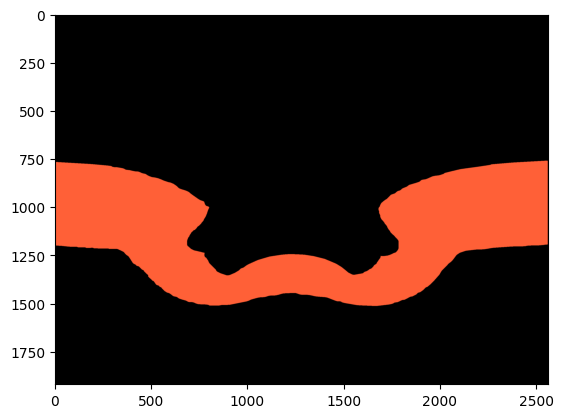

In [84]:
img = Image.open(image_path_list[0])

img_arr = np.array(img)

colour = LOWER

mask = np.all(img_arr == colour, axis=-1)
part_img = np.zeros_like(img_arr)
part_img[mask] = colour
plt.imshow(part_img)
plt.show()